<a href="https://colab.research.google.com/github/aln21-ua/TFM-PINNs/blob/main/Solucion_PINN_con_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías

In [ ]:
# Cálculo numérico y NNs
import numpy as np
import torch
import torch.nn as nn
from torch.optim import LBFGS, Adam

# Aleatoriedad
import random

# Barra de progreso
from tqdm import tqdm

# Visualización de gráficas y animación
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Visualización de la animación en Colab
from IPython.display import HTML

# Importar modelo
mountdrive = True
if mountdrive == True:
  # Guardar archivos en drive
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/TFM/pinnsformer-main
  from util import *
  from model.pinn import PINNs
  from model.pinnsformer import PINNsformer
  %cd ../../../../../
else:
  !git --version
  !git clone https://github.com/AdityaLab/pinnsformer.git
  %cd pinnsformer
  from util import *
  from model.pinn import PINNs
  from model.pinnsformer import PINNsformer
  %cd ..

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1XqjGe6HBQND2euar9zJTweIU5RMOflS4/TFM/pinnsformer-main
/content


# 1- Parámetros de la simulación

## Configuraciones

In [ ]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:0'
#device="cpu"

## Parámetros del sistema

Dada la PDE:

$$\frac{\partial^2 u}{\partial t^2}+2\beta \frac{\partial u}{\partial t}=c^2 \frac{\partial^2 u}{\partial x^2}$$

In [ ]:
# Parámetro de la amortiguación
beta = 0.5

# Velocidad de la onda
c = 1.0

## Parámetros de cálculo
Con una longitud de cuerda $L$ y un tiempo máximo de simulación $T$.

In [ ]:
# Longitud de la cuerda
L = 1.0

# Tiempo máximo de simulación
T = 10.0

# Discretización espacial y temporal
Nx = 51  # Número de puntos espaciales
Nt = 61  # Número de puntos temporales
x = np.linspace(0, L, Nx)
t = np.linspace(0, T, Nt)

## Tensor espacio-temporal inicial

In [ ]:
res, b_left, b_right, b_upper, b_lower = get_data([0,L], [0,T], Nx, Nt)
# para comparar con los datos reales
res_data, _, _, _, _ = get_data([0,L], [0,T], Nx, Nt)
res_data = torch.tensor(res_data, dtype=torch.float32, requires_grad=True).to(device)
x_data, t_data = res_data[:,0:1], res_data[:,1:2]
res_test, _, _, _, _ = get_data([0,L], [0,T], Nx, Nt)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,0:1], res[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]
x_upper, t_upper = b_upper[:,0:1], b_upper[:,1:2]
x_lower, t_lower = b_lower[:,0:1], b_lower[:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

## Instanciar modelo: PINN

In [ ]:
model = PINNs(in_dim=2, hidden_dim=512, out_dim=1, num_layer=4).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')

n_params = get_n_params(model)

print(model)
print(get_n_params(model))

<ipython-input-5-8a6e5e2f444a>:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


PINNs(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)
527361


# 2- Resolución: entrenamiento de PINN

Se propone:




## PDE
0. $\frac{\partial^2 u}{\partial t^2}+2\beta \frac{\partial u}{\partial t}=c^2 \frac{\partial^2 u}{\partial x^2}$

In [ ]:
def PDE(u_t, u_tt, u_x, u_xx):
  pde = u_tt + 2*beta*u_t - c**2*u_xx
  return pde - 0

## Condiciones iniciales
1. $u(x,t=0) = A \sin (\frac{k\pi}{L} x)$
2. $\frac{\partial u}{\partial t}(x, t=0)=0$

$A$ es la amplitud de la cuerda y $k \in \mathbb{N}$ define el número de nodos.

In [ ]:
A = 1
k = 1

def CondicionesIniciales_1(pred_left):
  u_x0 = A*torch.sin(k*pi/L * x_left[:,0])
  return pred_left[:,0] - u_x0

def CondicionesIniciales_2(ui_t):
  return ui_t - 0

## Condiciones de frontera
$$u(x=0,t)=u(x=L,t)=0$$

In [ ]:
def CondicionesFrontera_1(pred_upper):
  return pred_upper - 0

def CondicionesFrontera_2(pred_lower):
  return pred_lower - 0

## Obtener datos reales

Cargamos los datos reales como si fueran medidas del mundo real.

In [ ]:
if mountdrive == True:
  TFM_route = "/content/drive/MyDrive/TFM/Implementacion/"
  simulation_name = "Ecuacion de onda amortiguada/"
  u_tx_real = np.load(TFM_route+simulation_name+"u_tx_real.npy")
else:
  u_tx_real = np.load("u_tx_real.npy")

Seleccionamos un `perc`% de medidas en posiciones aleatorias.

In [ ]:
perc=10
num_elements = int(Nt*Nx*perc/100)
np.random.seed(0)
indices_flat = np.random.choice(u_tx_real.size, num_elements, replace=False)
t_i, x_i = np.unravel_index(indices_flat, u_tx_real.shape)

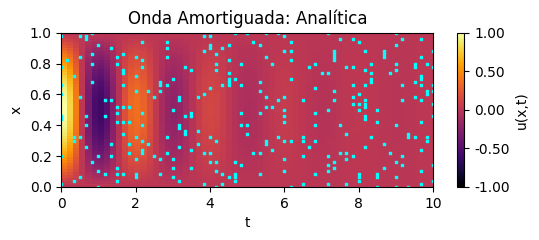

In [ ]:
plt.figure(figsize=(6, 2))
plt.imshow(u_tx_real[:,::-1].T, extent=[np.min(t), np.max(t), np.min(x), np.max(x)], aspect='auto', interpolation='nearest', cmap = "inferno", vmin=-A, vmax=A)
cbar = plt.colorbar(label='u(x,t)')
ticks = np.linspace(-A, A,5)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{tick:.2f}' for tick in ticks])
plt.scatter(t[t_i], x[x_i], color='cyan', marker='s', s=1)
plt.xlabel('t')
plt.ylabel('x')
plt.ylim([0,L])
plt.title('Onda Amortiguada: Analítica')
plt.show()

In [ ]:
u_data = torch.tensor((u_tx_real.copy()).reshape([Nx*Nt,1]), dtype=torch.float32, requires_grad=True).to(device)

In [ ]:
def DatosReales(pred_data):
  #return pred_res[flat_indexes] - u_data_real
  return pred_data[indices_flat] - u_data[indices_flat]

## Entrenamiento

In [ ]:
loss_track = []
pi = torch.tensor(np.pi, dtype=torch.float32, requires_grad=False).to(device)

for i in tqdm(range(100)):
    def closure():

        # PREDICCIONES
        # - General
        pred_res = model(x_res, t_res)
        # - Instante inicial
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        # - Frontera
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)
        # - Para comparar con datos reales
        pred_data = model(x_data, t_data)

        # CÁLCULO DE DERIVADAS
        # - General
        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_tt = torch.autograd.grad(u_t, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        # - Instante inicial
        ui_t = torch.autograd.grad(pred_left, t_left, grad_outputs=torch.ones_like(pred_left), retain_graph=True, create_graph=True)[0]

        # FUNCIÓN DE PÉRDIDA
        # - Ecuación del sistema
        loss_res = torch.mean(PDE(u_t, u_tt, u_x, u_xx)**2)
        # - Condiciones iniciales
        loss_ic = torch.mean(CondicionesIniciales_1(pred_left)**2) + torch.mean(CondicionesIniciales_2(ui_t)**2)
        # - Condiciones de frontera
        loss_bc = torch.mean(CondicionesFrontera_1(pred_upper)** 2) + torch.mean(CondicionesFrontera_2(pred_lower)** 2)
        # - Datos reales
        loss_data = torch.mean(DatosReales(pred_data)**2)

        # Guardar las diferentes partes de la función de pérdida
        loss_track.append([loss_res.item(), loss_ic.item(), loss_bc.item(), loss_data.item()])

        # Sumar
        loss = loss_res + loss_ic + loss_bc + loss_data

        optim.zero_grad()
        loss.backward()
        return loss

    optim.step(closure)

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


In [ ]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

torch.save(model.state_dict(), './Amortiguada_pinns.pt')

Loss Res: 0.000131, Loss_BC: 0.000013, Loss_IC: 0.000474
Train Loss: 0.001284


# 3- Cálculo de $u(x,t)$ y guardado de datos

In [ ]:
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,0:1], res_test[:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

u_tx = pred.reshape(Nt,Nx)
# tiempo i, posición j: u_tx[i,j]

Guardar solución para otras implementaciones.

In [ ]:
if mountdrive == True:
  TFM_route = "/content/drive/MyDrive/TFM/Implementacion/"
  simulation_name = "Ecuacion de onda amortiguada/"
  np.save(TFM_route+simulation_name+"u_tx_PINN_Datos.npy", u_tx)
else:
  np.save("u_tx_PINN_Datos.npy", u_tx)

# 4- Visualizaciones

In [ ]:
if mountdrive == True:
  TFM_route = "/content/drive/MyDrive/TFM/Implementacion/"
  simulation_name = "Ecuacion de onda amortiguada/"
  u_tx = np.load(TFM_route+simulation_name+"u_tx_PINN_Datos.npy")
else:
  u_tx = np.load("u_tx_PINN_Datos.npy")

## Mapa de calor

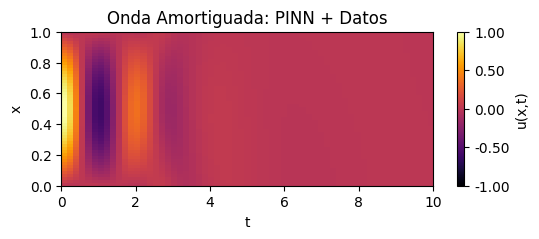

In [ ]:
plt.figure(figsize=(6, 2))
plt.imshow(u_tx[:,::-1].T, extent=[np.min(t), np.max(t), np.min(x), np.max(x)], aspect='auto', interpolation='nearest', cmap="inferno", vmin=-A, vmax=A)
cbar = plt.colorbar(label='u(x,t)')
ticks = np.linspace(-A, A,5)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{tick:.2f}' for tick in ticks])
plt.xlabel('t')
plt.ylabel('x')
plt.ylim([0,L])
plt.title('Onda Amortiguada: PINN + Datos')
plt.show()

## Animación

In [ ]:
# Función para actualizar animación
def actualizar(frame):
    line.set_ydata(u_tx[frame])
    tiempo_text.set_text(f't: {t[frame]:.2f}')
    return line, tiempo_text

In [ ]:
# Crear figura
fig, ax = plt.subplots()
ax.set_xlim(0, L)
ax.set_ylim(-A*1.1, A*1.1)
ax.set_xlabel('x')
ax.set_ylabel('u(x,t)')
ax.set_title('Onda Amortiguada: PINN + Datos')

# Imagen inicial
line, = ax.plot(x, u_tx[0])
tiempo_text = ax.text(0.95, 0.95, '', transform=ax.transAxes, ha='right', va='top', fontsize=12)

# Actualizar
ani = animation.FuncAnimation(fig, actualizar, frames=Nt, interval=50, blit=True)

# Mostrar la animación en Google Colab
plt.close("all")
HTML(ani.to_jshtml())